# Does everything to run entropy and creates slurm files to submit

## Run entropy with all diploid likelihoods from bcftools and all tetraploid likelihoods from ebg

Goal is 4 chains k=2-7.

**Creates mpgl file from PL in vcf and post-ebg**. 
Use ARTR.diseq.all.long-PL.txt

**full pntest_mean and mpgl all file taken from 6entropy_sagebrush_diploidAll**  
Rename pntest_mean_final_snps.recode.txt to pntest_mean_allDiploid.txt  
Rename final_snps.recode.mpgl to mpgl_diploidAll.txt


In [8]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [9]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [10]:
root = '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall'

In [11]:
cd $root

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall


### Create mgpl & pntest files with associated dir   

Uses custom R script to do so

In [12]:
ent_dir =os.path.join(root,'entropy_ebgAll')
assert ent_dir

In [6]:
!mkdir $ent_dir

mkdir: cannot create directory ‘/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll’: File exists


In [13]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll


### move ebg PL txt, and Pop_ID to ent dir, extract PL data   

In [14]:
%load_ext rpy2.ipython

In [16]:
%%R
require(readr)
library(data.table)
require(MASS)
require(LEA)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/')

R[write to console]: Loading required package: LEA



In [24]:
%%R 
#read in data
PL_4 <- data.frame(fread('ARTR.diseq.all.long-PL.txt',header=F,sep='\t'))
pntest_mean_2 <- data.frame(fread('pntest_mean_diploidAll.txt'))
mpgl_2 <- data.frame(fread('mpgl_diploidAll.txt',header=FALSE),row.names=1)

Pop_ID_OG <- read.csv('Pop_ID.csv')
Pop_ID_4 <- read.csv('Pop_ID_4.csv')

In [25]:
%%R
# REMOVE LAST COLUMN of PL_4 for some reason
PL_4 <- PL_4[,-c(ncol(PL_4))]

In [26]:
%%R
print(dim(Pop_ID_OG))
print(dim(Pop_ID_4))

print(dim(pntest_mean_2))
print(pntest_mean_2[1:5,1:5])
print(dim(mpgl_2))
print(mpgl_2[1:5,1:5])
print(dim(PL_4))
print(PL_4[1:5,(ncol(PL_4)-5):ncol(PL_4)])

[1] 690   6
[1] 291   6
[1] 17201   690
       V1      V2      V3      V4      V5
1      NA 0.33408 0.11182 0.01560 0.00397
2      NA      NA      NA      NA 0.00199
3 0.96935 0.11182 0.99999 0.99373 0.99999
4 0.03065 0.11182      NA      NA      NA
5 1.88818 1.88818      NA 1.66586 0.00397
[1] 17201  2070
                   V2 V3  V4 V5 V6
CM042338.1:1496841  0  0   0  0  3
CM042338.1:1942811  0  0   0  0  0
CM042338.1:6353755 15  0 125  0  9
CM042338.1:7214312  0 15 119  0  9
CM042338.1:8063221 83  9   0 83  9
[1] 17201   291
                                      V286
1 0.153749,15.7687,21.9222,27.9699,35.6823
2   0.421567,10.5304,24.005,45.7205,167.91
3 89.0786,8.98574,0.899493,12.1632,96.0032
4  0.0100082,26.3883,53.206,94.887,343.712
5  6.17937,4.67179,5.48689,8.73378,28.5995
                                        V287
1   0.153611,15.7767,21.9171,27.9488,35.6412
2    2.93294,5.57966,8.53542,12.3292,18.0407
3     12.0577,2.98226,4.5703,10.6994,35.9291
4 0.00237803,32.6181,68.1933

In [27]:
%%R
#converts pl to mpgl format
mpgl_4 <- apply(PL_4, c(1,2), function(df) gsub(',',' ',df,fixed=TRUE))

In [28]:
%%R
#check pl and mggl
print(PL_4[1:5,1:5])
print(mpgl_4[1:5,1:5])

                                        V1
1    0.150458,15.9607,21.8142,27.49,34.737
2 0.127178,15.4366,35.8402,69.2723,268.736
3    2.61834,4.96749,9.4069,17.1015,43.251
4 0.135163,15.4984,26.2648,40.6905,108.081
5     5.93821,4.71305,5.61953,8.80243,28.4
                                         V2
1     0.146678,16.1875,21.72,26.993,33.7245
2   45.8179,0.663488,8.51544,30.469,186.959
3  24.5822,0.969324,7.11379,26.5886,115.856
4 0.00680269,28.0613,56.0783,100.01,367.986
5   41.6976,6.26835,3.07722,5.66472,40.3514
                                         V3
1  0.144087,16.3471,21.6726,26.6825,33.0704
2   0.20459,13.4619,30.2096,57.2541,217.197
3   0.54769,9.27579,34.7382,80.2467,261.227
4 0.00155976,34.449,71.0486,129.674,497.858
5   2.08761,5.14476,11.4708,23.4574,96.1895
                                        V4
1 0.151819,15.8807,21.8558,27.6829,35.1204
2  2.89675,5.66263,8.57395,12.2446,17.7555
3  1.45556,6.14357,13.9856,27.4233,76.0823
4 0.396639,11.9401,17.5535,23.1561,30.4054

In [29]:
%%R
rownames(mpgl_4) <- rownames(mpgl_2)
print(dim(mpgl_4))
fwrite(mpgl_4,'mpgl_4.txt',quote=F,col.names = F,sep = ' ') 

[1] 17201   291


R[write to console]: x being coerced from class: matrix to data.table



In [30]:
%%R
### pntest_mean ploidy###
mean_pl <- function(GP){
  gps <- as.numeric(unlist(strsplit(as.character(GP),split = ',')))
  ploidy <- length(gps)-1
  if (sum(gps) == 0){
    mean <- 0
  }else{
    gps <- 10 ^ (gps/-10)
    mean <- sum(gps*(0:ploidy))/sum(gps)
    return(mean) 
  }
}

system.time(pntest_mean_4 <- apply(PL_4,1:2,mean_pl))

   user  system elapsed 
121.251   1.132 122.360 


In [31]:
%%R 
rownames(pntest_mean_4) <- rownames(mpgl_2)
print(dim(pntest_mean_4))

fwrite(pntest_mean_4,'pntest_mean_4.txt',quote=F,sep = ' ')

[1] 17201   291


R[write to console]: x being coerced from class: matrix to data.table



In [32]:
%%R
#make sure ploidy makes sense
print(apply(pntest_mean_4,2,function(df) range(df, na.rm=TRUE)))

               V1           V2           V3           V4           V5
[1,] 3.338874e-13 7.461051e-13 1.295388e-13 1.056088e-33 7.580537e-34
[2,] 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00
               V6          V7           V8           V9          V10
[1,] 1.827259e-13 3.19595e-33 1.838654e-33 3.021343e-15 1.531087e-19
[2,] 4.000000e+00 4.00000e+00 4.000000e+00 4.000000e+00 4.000000e+00
              V11          V12          V13          V14          V15
[1,] 7.996501e-32 3.254123e-07 1.970607e-26 7.413102e-26 3.956508e-08
[2,] 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00
              V16          V17          V18          V19          V20
[1,] 4.523244e-07 3.253869e-18 3.155005e-26 3.658474e-28 6.891282e-15
[2,] 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00 4.000000e+00
              V21          V22          V23          V24          V25
[1,] 1.243083e-13 8.949525e-17 1.100779e-13 2.860882e-23 1.593309e-12
[2,] 4.000000e+00 4.000

In [33]:
%%R
print(dim(pntest_mean_4))
print(pntest_mean_4[1:5,1:5])

[1] 17201   291
                           V1          V2           V3         V4          V5
CM042338.1:1496841 0.04520895 0.045209167 0.0452089686 0.04520878 0.004762917
CM042338.1:1942811 0.02911985 1.142521513 0.0469733411 0.79520477 1.399501901
CM042338.1:6353755 0.60653375 1.195271691 0.1188183140 0.32833621 0.429364844
CM042338.1:7214312 0.03317674 0.001567614 0.0003591617 0.11725048 0.023284305
CM042338.1:8063221 1.28723926 2.035260471 0.4619376125 0.68769952 2.124094297


## merge needed diploids and tetraploids to make new files 

In [35]:
%%R
Pop_ID_OG <- read.csv('Pop_ID.csv')
Pop_ID_4 <- read.csv('Pop_ID_4.csv')

pntest_mean_2 <- data.frame(fread('pntest_mean_diploidAll.txt'))
mpgl_2 <- data.frame(fread('mpgl_diploidAll.txt',header=FALSE),row.names=1)

pntest_mean_4 <- data.frame(fread('pntest_mean_4.txt'))
mpgl_4 <- data.frame(fread('mpgl_4.txt',header=FALSE))


In [36]:
%%R
print(dim(Pop_ID_OG))
print(dim(pntest_mean_2))
print(dim(mpgl_2))

print(dim(Pop_ID_4))
print(dim(pntest_mean_4))
print(dim(mpgl_4))

[1] 690   6
[1] 17201   690
[1] 17201  2070
[1] 291   6
[1] 17201   291
[1] 17201  1455


In [37]:
%%R
#extract only diploids for mpgl 
#first make a header for mpgl_2 so can select the right indv
names3 <- rep(Pop_ID_OG$All,each=3)
names(mpgl_2) <- names3
only2_names <- Pop_ID_OG$All[which(Pop_ID_OG$Ploidy == 2)]
index_mpgl2 <- which(names(mpgl_2) %in% only2_names)
mpgl_2only <- mpgl_2[,index_mpgl2]

#only diploids for rest
pntest_mean_2only <- pntest_mean_2[,which(Pop_ID_OG$Ploidy == 2)]
Pop_ID_2only <- Pop_ID_OG[which(Pop_ID_OG$Ploidy == 2),]

In [38]:
%%R
print(dim(Pop_ID_2only))
print(dim(pntest_mean_2only))
print(dim(mpgl_2only))

[1] 399   6
[1] 17201   399
[1] 17201  1197


In [39]:
%%R

pntest_mean_ebgAll <- cbind(pntest_mean_2only,pntest_mean_4)
mpgl_ebgAll <- cbind(mpgl_2only,mpgl_4)
Pop_ID_ebgAll <- rbind(Pop_ID_2only,Pop_ID_4)


In [40]:
%%R
print(dim(Pop_ID_ebgAll))
print(dim(pntest_mean_ebgAll))
print(dim(mpgl_ebgAll))

#test right dim for mpgl
print((nrow(Pop_ID_2only)*3) + (nrow(Pop_ID_4)*5))

[1] 690   6
[1] 17201   690
[1] 17201  2652
[1] 2652


In [54]:
%%R
print(pntest_mean_ebgAll[1:5,1:5])

       V1      V2      V3      V4      V5
1      NA 0.33408 0.11182 0.01560 0.00397
2      NA      NA      NA      NA 0.00199
3 0.96935 0.11182 0.99999 0.99373 0.99999
4 0.03065 0.11182      NA      NA      NA
5 1.88818 1.88818      NA 1.66586 0.00397


In [42]:
%%R
print(rownames(mpgl_2)[1:10])
rownames(mpgl_ebgAll) <- rownames(mpgl_2)


 [1] "CM042338.1:1496841" "CM042338.1:1942811" "CM042338.1:6353755"
 [4] "CM042338.1:7214312" "CM042338.1:8063221" "CM042338.1:8177835"
 [7] "CM042338.1:8530959" "CM042338.1:8548932" "CM042338.1:8655617"
[10] "CM042338.1:8690402"


In [55]:
%%R
rownames(mpgl_ebgAll) <- rownames(mpgl_2)
fwrite(mpgl_ebgAll,'mpgl_ebgAll.txt',quote=F,col.names = F,row.names=TRUE,sep = ' ') 
#change pntest NAs to 0 
fwrite(pntest_mean_ebgAll,'pntest_mean_ebgAll.txt',na=0,col.names = F,sep = ' ') 
write.csv(Pop_ID_ebgAll,'Pop_ID_ebgAll.csv',row.names=F)

## Create ldak files in R: standardize by ploidy! 

see mixed_ploidy_PCA.Rmd

In [56]:
%%R
#read in data 
Pop_ID <- read.csv("Pop_ID_ebgAll.csv")
pntest_mean <- fread("pntest_mean_ebgAll.txt",header=F, data.table=F)

g <- t(pntest_mean)

###make sure all NA to 0 
#g[is.na(g)]<-0
print(length(which(is.na(g))))
print(dim(g))
g[1:5,1:5]

[1] 0
[1]   690 17201
      [,1]    [,2]    [,3]    [,4]    [,5]
V1 0.00000 0.00000 0.96935 0.03065 1.88818
V2 0.33408 0.00000 0.11182 0.11182 1.88818
V3 0.11182 0.00000 0.99999 0.00000 0.00000
V4 0.01560 0.00000 0.99373 0.00000 1.66586
V5 0.00397 0.00199 0.99999 0.00000 0.00397


In [57]:
%%R
#### create pl_list ####

pl_list <- Pop_ID$Ploidy

#### get stats on g and ploidy ####

nind <- nrow(g)
nloci <- ncol(g)
n2_index <- which(pl_list == 2)
n4_index <- which(pl_list == 4)

#### check distributions  / range ###
g2 <- g[n2_index,]
g4 <- g[n4_index,]

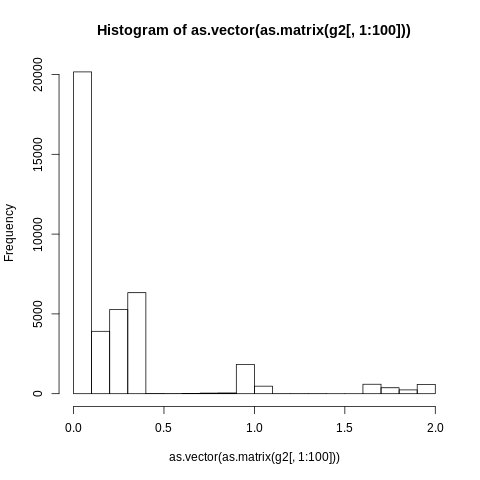

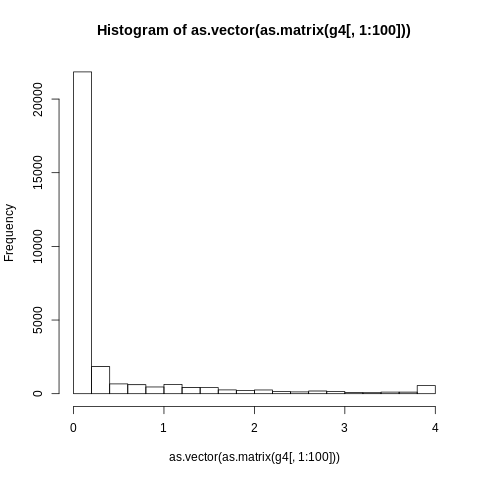

In [58]:
%%R
hist(as.vector(as.matrix(g2[,1:100])))
hist(as.vector(as.matrix(g4[,1:100])))

In [59]:
%%R
g2 <- g[n2_index,]
g4 <- g[n4_index,]
g2_scale <- scale(g2)
g4_scale <- scale(g4)

g_z <- rbind(g2_scale,g4_scale)

### if NAs
g_z[is.na(g_z)] <- 0

z_pca <- prcomp(as.matrix(g_z),scale. = F, center = F)
pve <- summary(z_pca)$importance[2,1:5]
print(summary(z_pca)$importance[2:3,1:5])

pca_df <- cbind(rbind(Pop_ID[n2_index,],Pop_ID[n4_index,]),
                  z_pca$x[,1:5])

                           PC1     PC2     PC3     PC4     PC5
Proportion of Variance 0.03627 0.01420 0.01061 0.00850 0.00764
Cumulative Proportion  0.03627 0.05047 0.06107 0.06958 0.07721


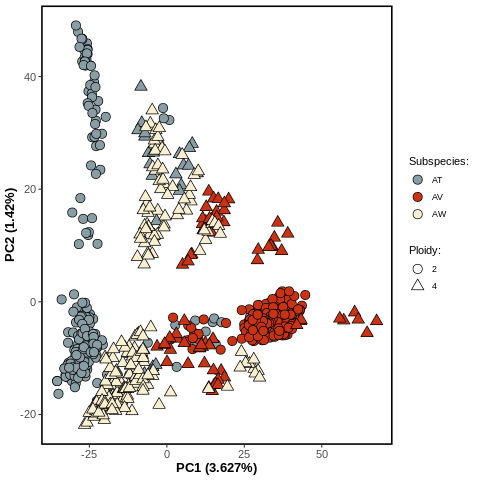

In [61]:
%%R
col3 <- c("#899DA4","#C93312","#FAEFD1")
ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=Sp,shape=as.character(Ploidy))) + 
  geom_point(colour='black',size = 4)+ #ggtitle("PCA ARTR all") +
  xlab(paste("PC",1," (",pve[1]*100,"%)",sep="")) + ylab(paste("PC",2," (",pve[2]*100,"%)",sep=""))  +
  scale_fill_manual(name='Subspecies:',values = col3) +
  scale_shape_manual(name='Ploidy:',values = c(21,24)) + 
  guides(fill = guide_legend(override.aes=list(pch=21))) +
  theme_bw() + 
  theme(#legend.position = 'none',
    axis.text = element_text(size=11), 
    axis.title = element_text(size = 13, colour="black",face = "bold",vjust = 1),
    panel.border = element_rect(size = 1.5, colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank())

In [62]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(z_pca$x[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(z_pca$x[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(z_pca$x[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(z_pca$x[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(z_pca$x[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(z_pca$x[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(z_pca$x[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(z_pca$x[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(z_pca$x[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(z_pca$x[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=z_pca$x[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=z_pca$x[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=z_pca$x[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=z_pca$x[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=z_pca$x[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=z_pca$x[,1:5],grouping=k7$cluster,CV=TRUE)
#ldak8<-lda(x=z_pca$x[,1:5],grouping=k8$cluster,CV=TRUE)
#ldak9<-lda(x=z_pca$x[,1:5],grouping=k9$cluster,CV=TRUE)
#ldak10<-lda(x=z_pca$x[,1:5],grouping=k10$cluster,CV=TRUE)
#ldak11<-lda(x=z_pca$x[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
#write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [63]:
%%R
###### Create ploidy inds.txt ######
ploidy_inds <- data.frame(Ploidy=Pop_ID$Ploidy)
write.table(ploidy_inds,'ploidy_inds.txt',quote=F,row.names=F,col.names=F)

In [64]:
!head ploidy_inds.txt
!wc -l ploidy_inds.txt

2
2
2
2
2
2
2
2
2
2
690 ploidy_inds.txt


In [65]:
%%R
######### create entropy header ####

Pop_ID_list <- Pop_ID$All

Header <- data.frame(dims = NA,Pop_ID_list)

dim(pntest_mean)

df <- t(Header)
dims <- paste(dim(pntest_mean)[2],dim(pntest_mean)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [66]:
!head entropy_header.txt

690 17201                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14 AT2_BB_15 AT2_BB_16 AT2_BB_17 AT2_BB_1 AT2_BB_2 AT2_BB_3 AT2_BB_4 AT2_BB_5 AT2_BB_6 AT2_BB_7 AT2_BB_8 AT2_BB_9 AT2_BC_17 AT2_BC_18 AT2_BC_19 AT2_BC_20 AT2_BC_21 AT2_BC_22 AT2_BC_23 AT2_BT_1 AT2_BT_2 AT2_BT_3 AT2_BT_4 AT2_BT_57 AT2_BT_58 AT2_BT_59 AT2_

In [67]:
!cat entropy_header.txt mpgl_ebgAll.txt > entropy.mpgl

In [68]:
!head entropy.mpgl

690 17201                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
AT2_BB_10 AT2_BB_11 AT2_BB_12 AT2_BB_13 AT2_BB_14 AT2_BB_15 AT2_BB_16 AT2_BB_17 AT2_BB_1 AT2_BB_2 AT2_BB_3 AT2_BB_4 AT2_BB_5 AT2_BB_6 AT2_BB_7 AT2_BB_8 AT2_BB_9 AT2_BC_17 AT2_BC_18 AT2_BC_19 AT2_BC_20 AT2_BC_21 AT2_BC_22 AT2_BC_23 AT2_BT_1 AT2_BT_2 AT2_BT_3 AT2_BT_4 AT2_BT_57 AT2_BT_58 AT2_BT_59 AT2_

In [69]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll


In [70]:
!mkdir shdir

In [71]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '14-00:00:00' #time limit 14 days
cpus = 1 #to prevent hammering one node
mem_cpu = 16000
email = 'tfaske@nevada.unr.edu'

#entropy settings
ploidy = 'ploidy_inds.txt'
l = 60000
b = 10000
num_k = [2,3,4,5,6,7]
chains = 4

In [72]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,ploidy,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n ../%s -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,ploidy,l,b,k,k))
    

In [73]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,ploidy,l,b,num_k,chains)

In [74]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall

In [75]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [76]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/home/tfaske/d/connie/ch2/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [131]:
np.set_printoptions(precision=8) # increases float print option
pd.set_option("precision", 8)

In [132]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll


In [133]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
hdf5_files

['./entropy_k2_c1.hdf5',
 './entropy_k2_c2.hdf5',
 './entropy_k2_c3.hdf5',
 './entropy_k2_c4.hdf5',
 './entropy_k3_c1.hdf5',
 './entropy_k3_c2.hdf5',
 './entropy_k3_c3.hdf5',
 './entropy_k3_c4.hdf5',
 './entropy_k4_c1.hdf5',
 './entropy_k4_c2.hdf5',
 './entropy_k4_c3.hdf5',
 './entropy_k4_c4.hdf5',
 './entropy_k5_c1.hdf5',
 './entropy_k5_c2.hdf5',
 './entropy_k5_c3.hdf5',
 './entropy_k5_c4.hdf5',
 './entropy_k6_c1.hdf5',
 './entropy_k6_c2.hdf5',
 './entropy_k6_c3.hdf5',
 './entropy_k6_c4.hdf5',
 './entropy_k7_c1.hdf5',
 './entropy_k7_c2.hdf5',
 './entropy_k7_c3.hdf5',
 './entropy_k7_c4.hdf5']

In [134]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [135]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [136]:
dic_files = !find . -name 'DIC*'
dic_files

['./DIC_k2_c4.txt',
 './DIC_k7_c2.txt',
 './DIC_k2_c1.txt',
 './DIC_k6_c1.txt',
 './DIC_k3_c2.txt',
 './DIC_k4_c4.txt',
 './DIC_k4_c2.txt',
 './DIC_k7_c1.txt',
 './DIC_k7_c4.txt',
 './DIC_k5_c2.txt',
 './DIC_k6_c2.txt',
 './DIC_k4_c3.txt',
 './DIC_k7_c3.txt',
 './DIC_k3_c1.txt',
 './DIC_k2_c2.txt',
 './DIC_k5_c4.txt',
 './DIC_k6_c3.txt',
 './DIC_k4_c1.txt',
 './DIC_k2_c3.txt',
 './DIC_k6_c4.txt',
 './DIC_k3_c4.txt',
 './DIC_k5_c1.txt',
 './DIC_k3_c3.txt',
 './DIC_k5_c3.txt']

In [137]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 20623460.89
Effective number of parameters: 25243177.88
Model DIC: 45866638.77


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 19093497.00
Effective number of parameters: 53693341.48
Model DIC: 72786838.47


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 20622801.34
Effective number of parameters: 25244205.29
Model DIC: 45867006.63


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 19459663.02
Effective number of parameters: 40591396.13
Model DIC: 60051059.16


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 20336245.49
Effective number of parameters: 36674842.61
Model DIC: 57011088.10


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: sa

In [138]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,45866638.77,4
1,7,72786838.47,2
2,2,45867006.63,1
3,6,60051059.16,1
4,3,57011088.10,2


In [139]:
dic_df.to_csv('dic_list.csv')

In [140]:
dic_sum = dic_df.groupby('k').describe().DIC

In [141]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,4.55914226e+07,6.40324059e+05,44635337.69,4.55588135e+07,4.58668227e+07,4.58994318e+07,4.59967075e+07
3,4.0,5.61165970e+07,9.00718075e+05,54898112.11,5.57686667e+07,5.62785939e+07,5.66265242e+07,5.70110881e+07
6,4.0,6.23791179e+07,2.23240371e+06,60051059.16,6.08558936e+07,6.22090513e+07,6.37322756e+07,6.50473100e+07
4,4.0,7.69636321e+07,1.24546641e+07,58741630.54,7.54260887e+07,8.10963915e+07,8.26339348e+07,8.69201148e+07
7,4.0,7.71630705e+07,4.14012336e+06,72786838.47,7.48649747e+07,7.66411151e+07,7.89392110e+07,8.25832133e+07
5,4.0,8.69485788e+07,2.51980819e+07,61271865.86,6.93611534e+07,8.46334573e+07,1.02220883e+08,1.17255535e+08


In [142]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [143]:
# ancestry coeffecients 
#!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

#!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

#!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

#!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt



file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 690, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entropy_k7_c3.hdf5
file = entropy_k7_c4.hdf5
parameter dimensions for q: ind = 690, populations = 7, samples = 5000, chains = 4


In [144]:
#MCMC diagnostics
#!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

#!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

#!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

#!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 690, populations = 6, samples = 5000, chains = 4
file = entropy_k7_c1.hdf5
file = entropy_k7_c2.hdf5
file = entropy_k7_c3.hdf5
file = entropy_k7_c4.hdf5
parameter dimensions for q: ind = 690, populations = 7, samples = 5000, chains = 4


### make slurm script to make gprob file

    use all k and chains to make gprob

In [90]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll


In [91]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6,7]

In [92]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [93]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [94]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k6.sh',
 '/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/entropy_ebgAll/shdir/run_gprob_k7.sh']

In [95]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [96]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

In [97]:
hdf5_files = []
for k in num_k:
    f = '../entropy_k' + str(k) + '_c*hdf5'
    hdf5_files.append(f)
hdf5_files

['../entropy_k2_c*hdf5',
 '../entropy_k3_c*hdf5',
 '../entropy_k4_c*hdf5',
 '../entropy_k5_c*hdf5',
 '../entropy_k6_c*hdf5',
 '../entropy_k7_c*hdf5']

In [98]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c*hdf5 ../entropy_k3_c*hdf5 ../entropy_k4_c*hdf5 ../entropy_k5_c*hdf5 ../entropy_k6_c*hdf5 ../entropy_k7_c*hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [99]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [100]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [101]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 
    cd /data/gpfs/home/tfaske/d/milkweed/entropy
    source activate entropy
    sbatch run_gprob.sh

In [ ]:
#gprobs
#!$estpost *k2*.hdf5 -p gprob -s 0 -o gprob2.txt

#!$estpost *k3*.hdf5 -p gprob -s 0 -o gprob3.txt

#!$estpost *k4*.hdf5 -p gprob -s 0 -o gprob4.txt

#!$estpost *k5*.hdf5 -p gprob -s 0 -o gprob5.txt